In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1000
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(31 * 31, IMG_H * IMG_W)
        self.fc_var = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class VAE(nn.Module):
    def __init__(self, encoder, decoder, var=0.5):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.var = var

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        mu_x, log_var_x = self.decoder(z)
        return mu_z, log_var_z, mu_x, log_var_x

    def reconstruct(self, mu_x, log_var_x):
        std = torch.exp(0.5 * log_var_x)
        epsilon = torch.randn_like(std).to(DEVICE)
        x_recon = torch.sigmoid(mu_x + std * epsilon)
        return x_recon.view(BATCH_SIZE, IMG_C, IMG_H, IMG_W)

    

In [5]:
LATENT_DIM = 20

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=20, bias=True)
    (fc_var): Linear(in_features=1152, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(20, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:05<01:38,  5.21s/it]

Epoch 1, Mean Training ELBO -12.279538422851562, Mean Validation ELBO -105.01120234375


 10%|█         | 2/20 [00:10<01:33,  5.19s/it]

Epoch 2, Mean Training ELBO -272.5176656640625, Mean Validation ELBO 1089.3532


 15%|█▌        | 3/20 [00:15<01:28,  5.19s/it]

Epoch 3, Mean Training ELBO -86.6212049609375, Mean Validation ELBO -500.624428125


 20%|██        | 4/20 [00:20<01:23,  5.21s/it]

Epoch 4, Mean Training ELBO -206.23676162109376, Mean Validation ELBO -521.492509375


 25%|██▌       | 5/20 [00:26<01:18,  5.21s/it]

Epoch 5, Mean Training ELBO -528.054958125, Mean Validation ELBO -552.50443125


 30%|███       | 6/20 [00:31<01:12,  5.21s/it]

Epoch 6, Mean Training ELBO -348.14609326171876, Mean Validation ELBO -561.9642125


 35%|███▌      | 7/20 [00:36<01:07,  5.19s/it]

Epoch 7, Mean Training ELBO 112.28031166015624, Mean Validation ELBO 115.31413828125


 40%|████      | 8/20 [00:41<01:02,  5.18s/it]

Epoch 8, Mean Training ELBO -322.2828477734375, Mean Validation ELBO -234.2934984375


 45%|████▌     | 9/20 [00:46<00:56,  5.17s/it]

Epoch 9, Mean Training ELBO -302.1411808984375, Mean Validation ELBO 165.98461875


 50%|█████     | 10/20 [00:51<00:51,  5.14s/it]

Epoch 10, Mean Training ELBO -327.8314713574219, Mean Validation ELBO -398.610828125


 55%|█████▌    | 11/20 [00:56<00:46,  5.13s/it]

Epoch 11, Mean Training ELBO -368.4398967578125, Mean Validation ELBO -85.70293359375


 60%|██████    | 12/20 [01:01<00:40,  5.11s/it]

Epoch 12, Mean Training ELBO -479.79343640625, Mean Validation ELBO -555.7677125


 65%|██████▌   | 13/20 [01:06<00:35,  5.09s/it]

Epoch 13, Mean Training ELBO -671.60406234375, Mean Validation ELBO -502.3416375


 70%|███████   | 14/20 [01:12<00:30,  5.10s/it]

Epoch 14, Mean Training ELBO -680.955413125, Mean Validation ELBO -858.6898


 75%|███████▌  | 15/20 [01:17<00:25,  5.09s/it]

Epoch 15, Mean Training ELBO -434.242228515625, Mean Validation ELBO 250.16883125


 80%|████████  | 16/20 [01:22<00:20,  5.09s/it]

Epoch 16, Mean Training ELBO -284.40599267578125, Mean Validation ELBO -682.5696


 85%|████████▌ | 17/20 [01:27<00:15,  5.08s/it]

Epoch 17, Mean Training ELBO -530.0880328125, Mean Validation ELBO -598.23566875


 90%|█████████ | 18/20 [01:32<00:10,  5.09s/it]

Epoch 18, Mean Training ELBO -622.949878125, Mean Validation ELBO -228.4377484375


 95%|█████████▌| 19/20 [01:37<00:05,  5.11s/it]

Epoch 19, Mean Training ELBO -457.0781578125, Mean Validation ELBO -700.8977375


100%|██████████| 20/20 [01:42<00:00,  5.14s/it]

Epoch 20, Mean Training ELBO -787.7224375, Mean Validation ELBO -931.4149875


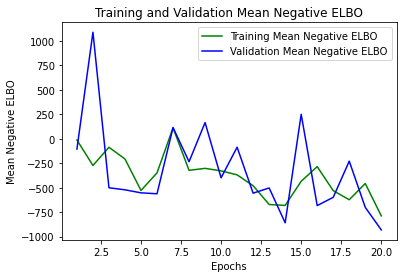

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, mu_x, log_var_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            distances = (x - mu_x) ** 2
            log_p = -0.5 * torch.sum(np.log(2 * np.pi) + log_var_x + distances / log_var_x.exp())
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, mu_x, log_var_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                distances = (x - mu_x) ** 2
                log_p = -0.5 * torch.sum(np.log(2 * np.pi) + log_var_x + distances / log_var_x.exp())
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()

        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()

train_vae(num_epochs=20, patience=22)

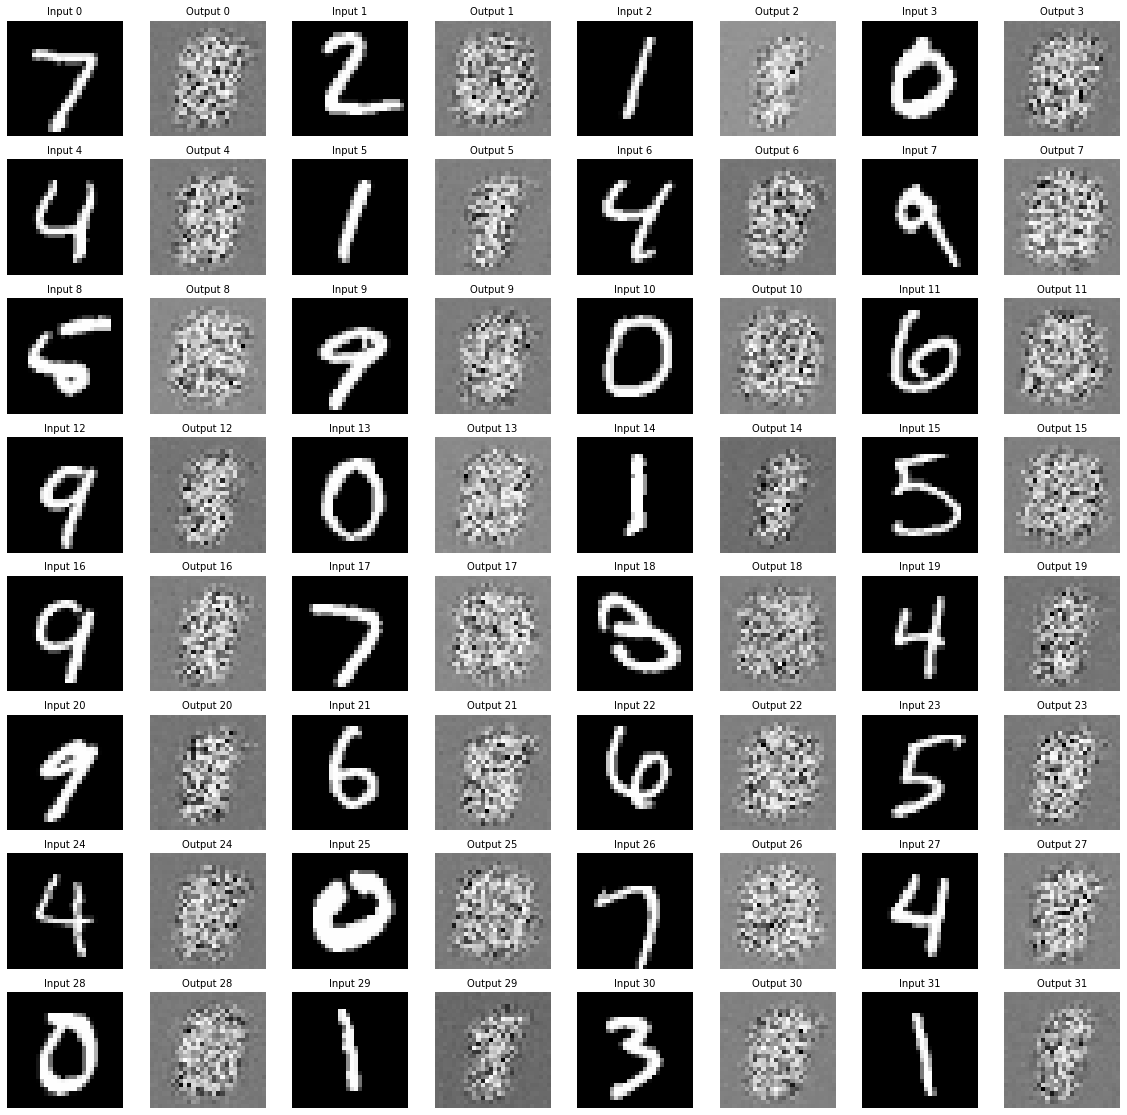

In [7]:
def test_vae():
    x, y = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, mu_x, log_var_x = vae(x)
        z_lat = encoder.reparameterization(mu_x,log_var_x )
        x_recon = vae.reconstruct(z_lat, log_var_x)
        return x, x_recon
test_batch, test_batch_recon = test_vae()

def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(BATCH_SIZE, IMG_H, IMG_W)
    x_recon = x_recon.view(BATCH_SIZE, IMG_H, IMG_W)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)

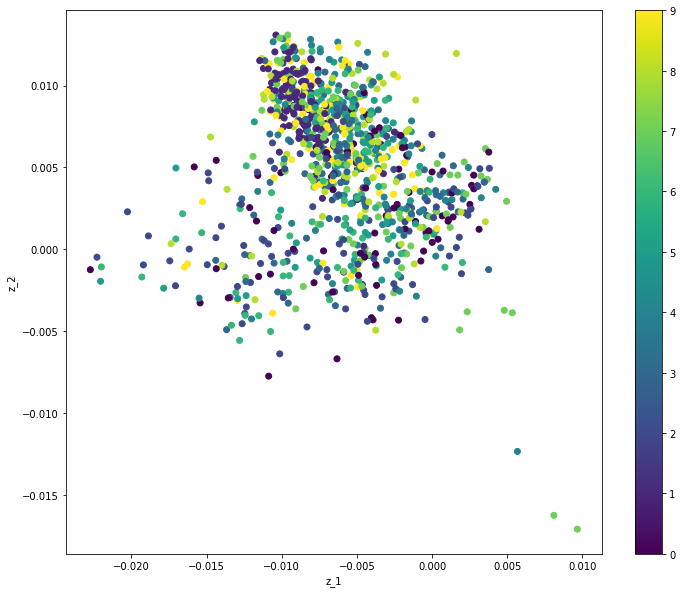

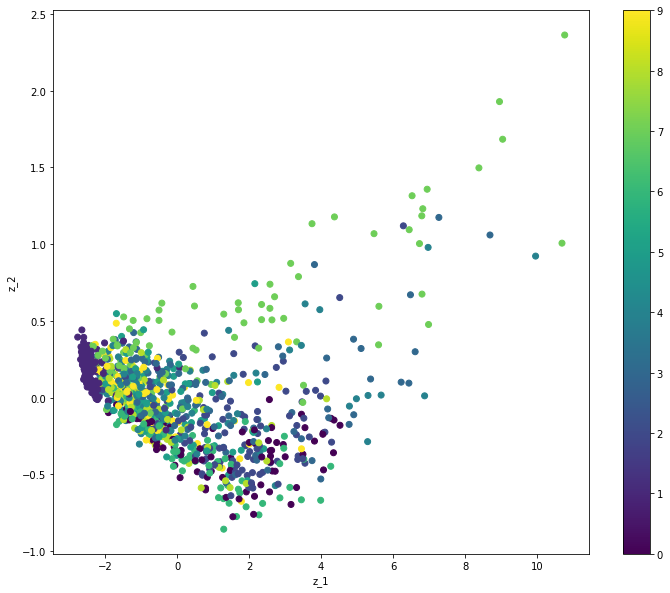

In [8]:
x_original_list = []
y_list = []
x_reconstr_list = []
mu_list = []
log_var_x_list = []
muz_list = []
pca_mu = []
def plot_a():
  x, y = next(iter(test_dataloader))
  x = x.to(DEVICE)
  with torch.no_grad():
    
      x_original_list.append(x)
      y_list.append(y)

      mu_z, _, mu_x, log_var_x = vae(x)
      mu_list.append(mu_x)
      muz_list.append(mu_z)
      log_var_x_list.append(log_var_x)
      x_reconstr = vae.reconstruct(mu_x, log_var_x)
      x_reconstr_list.append(x_reconstr)

  plt.figure(figsize=(12, 10))
  for mu, y in zip(mu_list, y_list):
      mu = mu.cpu().numpy()
      plt.scatter(mu[:, 0], mu[:, 1], c=y)
  plt.colorbar()
  plt.xlabel("z_1")
  plt.ylabel("z_2")
  plt.show()

def plot_b():
  
  lp = np.zeros((1000,LATENT_DIM))
  for mu in muz_list:
    lp=mu
  lp = torch.as_tensor(lp)
  lp = lp.cpu().numpy()
  pca = PCA(n_components=2)
  pca.fit(lp)
  pcu_mu = pca.transform(lp)
  pcu_mu = torch.as_tensor(pcu_mu)
  pca_mu.append(pcu_mu)

  plt.figure(figsize=(12, 10))
  for mu, y in zip(pca_mu, y_list):
      #mu = mu.cpu().numpy()
      plt.scatter(mu[:,0], mu[:,1], c=y)
  plt.colorbar()
  plt.xlabel("z_1")
  plt.ylabel("z_2")
  plt.show()

plot_a()
plot_b()


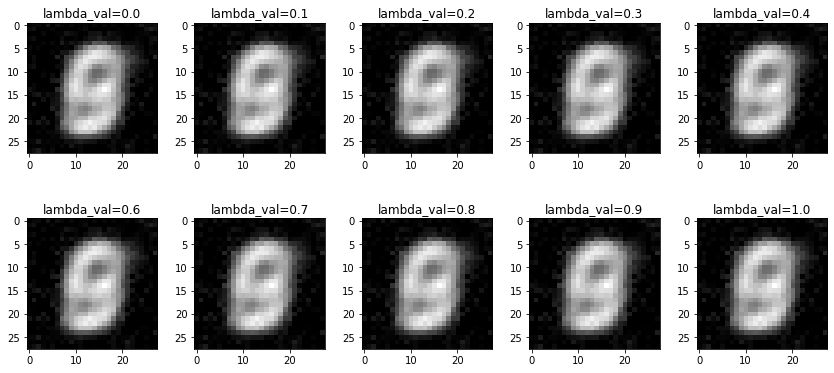

In [15]:

def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)    

def interpolation(lambda1, model, img1, img2):
  with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(DEVICE)
        latent_1, _ ,_ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(DEVICE)
        latent_2, _ ,_= model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2
        
        # reconstruct interpolated image
        #_, _, mu_x, log_var_x = vae(inter_latent)
        #z_lat = encoder.reparameterization(mu_x,log_var_x )
        #inter_image = vae.reconstruct(z_lat, log_var_x)

        inter_image = model.decoder(inter_latent)
        inter_image = inter_image
        inter_image = tuple_of_tensors_to_tensor(inter_image)
        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for x, y in test_dataloader:
    for i in range(x.size(0)):
        digits[y[i]].append(x[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;
        
digit1 = digits[1][0]
digit2 = digits[7][0]
lambda_range=np.linspace(0,1,10)
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = inter_image.clamp(0, 1)
    inter_image = torch.stack(list(inter_image), dim=0)
    inter_image = inter_image.view(2,1, IMG_H, IMG_W)
    image = inter_image.cpu().numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))